In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Text(0,0.5,u'$y$')

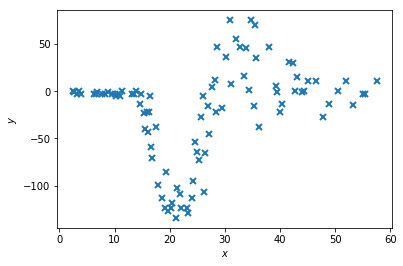

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
k1 = hetero_kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale(Xnorm, Y[:,None], k1, nonstat)

In [4]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp.V1,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.V2,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.kern1.lengthscales,[ 1.],None,+ve
adaptive_lengthscale_gp.kern1.variance,[ 1.],None,+ve
adaptive_lengthscale_gp.likelihood.variance,[ 1.],None,+ve
adaptive_lengthscale_gp.nonstat.signal_variance,[ 1.],None,+ve


In [5]:
#m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern1.variance.prior = gpflow.priors.Gamma(1.,1.)

m.kern1.lengthscales = 1.
m.kern1.lengthscales.fixed = True
m.kern1.variance = 1.
m.kern1.variance.fixed = True

m.likelihood.variance.prior = gpflow.priors.Gamma(1.,1.)
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1.,1.)

In [6]:
m.optimize(maxiter=1000) # start near MAP

      fun: array([ 955.25751247])
 hess_inv: <190x190 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.32237581e-02,   2.36893573e-02,   1.29602340e-02,
         2.06656540e-02,   1.85692753e-02,   2.04542510e-02,
         1.25778031e-02,   1.14211711e-02,   2.16549340e-02,
         8.40562776e-03,   9.29635370e-03,   1.05260660e-02,
         7.09827845e-03,   5.23889414e-03,   6.94159106e-03,
         7.34038751e-03,   6.99185250e-03,   1.13650903e-02,
         3.78277434e-03,   2.82794273e-03,   5.62783322e-03,
         3.03631235e-03,   3.82506515e-03,   2.41248024e-03,
         2.07172626e-03,   2.00973148e-03,   1.95522527e-03,
         1.69808591e-03,   1.43030999e-03,   1.52749472e-03,
         2.81640455e-03,   1.62456711e-03,   2.09775154e-03,
         1.74924956e-03,   8.94420030e-04,   5.45174941e-04,
         9.55660788e-04,   1.56525149e-03,   4.37772851e-04,
         2.38153531e-03,  -6.39794343e-04,   1.34134482e-03,
         9.41942067e-04,   3.66165401e-04

In [7]:
samples = m.sample(2000, verbose=True, epsilon=0.025, thin = 2, burn = 1000, Lmax = 80)

burn-in sampling started
Iteration:  100 	 Acc Rate:  93.0 %
Iteration:  200 	 Acc Rate:  98.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  98.0 %
Iteration:  500 	 Acc Rate:  96.0 %
Iteration:  600 	 Acc Rate:  97.0 %
Iteration:  700 	 Acc Rate:  98.0 %
Iteration:  800 	 Acc Rate:  98.0 %
Iteration:  900 	 Acc Rate:  94.0 %
Iteration:  1000 	 Acc Rate:  97.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  95.0 %
Iteration:  200 	 Acc Rate:  95.0 %
Iteration:  300 	 Acc Rate:  94.0 %
Iteration:  400 	 Acc Rate:  99.0 %
Iteration:  500 	 Acc Rate:  97.0 %
Iteration:  600 	 Acc Rate:  97.0 %
Iteration:  700 	 Acc Rate:  94.0 %
Iteration:  800 	 Acc Rate:  98.0 %
Iteration:  900 	 Acc Rate:  97.0 %
Iteration:  1000 	 Acc Rate:  96.0 %
Iteration:  1100 	 Acc Rate:  97.0 %
Iteration:  1200 	 Acc Rate:  97.0 %
Iteration:  1300 	 Acc Rate:  94.0 %
Iteration:  1400 	 Acc Rate:  96.0 %
Iteration:  1500 	 Acc Rate:  99.0 %
Iteration:  1600 	 Acc Rate:  95.0 %
Iteratio

In [8]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp.V1,[[ 2.66377943e+00] [ 6.02523557e-01] [ -3.54435645e-01] [ -8.44718661e-01] [ -8.25098419e-01] [ -1.16777586e+00] [ -9.65733334e-01] [ -9.00757723e-01] [ -1.77545111e+00] [ -7.31195805e-01] [ -8.78889825e-01] [ -1.08940478e+00] [ -7.80718953e-01] [ -5.96183769e-01] [ -8.29225924e-01] [ -9.07639955e-01] [ -8.91263556e-01] [ -1.60950499e+00] [ -6.00248533e-01] [ -4.75923437e-01] [ -1.03963965e+00] [ -5.88281126e-01] [ -8.00976359e-01] [ -5.23264643e-01] [ -4.41191864e-01] [ -4.32825748e-01] [ -4.18970992e-01] [ -4.16976040e-01] [ -4.52161510e-01] [ -4.51982357e-01] [ -7.92455157e-01] [ -5.03660024e-01] [ -7.12017383e-01] [ -6.01276950e-01] [ -3.62316783e-01] [ -3.26505722e-01] [ -5.17986481e-01] [ -3.66774200e-01] [ -5.66528055e-01] [ -3.24235176e-01] [ -3.42691934e-01] [ -2.62932034e-01] [ -5.49247841e-01] [ -2.49678402e-01] [ -3.19241117e-01] [ -2.25503640e-01] [ -2.66008079e-01] [ -2.58007842e-01] [ -2.44223305e-01] [ -2.00200167e-01] [ -2.14590171e-01] [ -1.56354609e-01] [ -1.45073432e-01] [ -2.12897849e-01] [ -1.45466288e-01] [ -1.59992061e-01] [ -1.85684095e-01] [ -1.27025050e-01] [ -1.06863101e-01] [ -1.84805477e-01] [ -1.89359657e-01] [ -1.71074717e-01] [ -9.36985931e-02] [ -1.46472278e-01] [ -1.49947010e-01] [ -1.19321713e-01] [ -9.29814601e-02] [ -1.06567024e-01] [ -8.89593871e-02] [ -8.57790372e-02] [ -6.30728217e-02] [ -5.55030471e-02] [ -8.86306222e-02] [ -1.44986582e-01] [ -9.19470095e-02] [ -4.00978557e-02] [ -5.97710221e-02] [ -5.35340654e-02] [ -7.77525479e-02] [ -4.82213567e-02] [ -3.06529676e-02] [ -2.13996902e-02] [ -4.05173887e-02] [ -2.55178514e-02] [ -2.51087967e-02] [ -3.24453647e-02] [ -1.82475691e-02] [ -1.22476346e-02] [ -1.11114861e-02] [ -4.76141372e-03] [ -2.26885588e-03] [ -8.34841010e-04] [ -2.28011078e-04] [ -2.51711425e-04]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.V2,[[-0.15473951] [-0.03138956] [-0.02333322] [-0.04851898] [-0.06920706] [-0.08195181] [-0.06847296] [-0.05033416] [-0.07458954] [-0.1007849 ] [-0.21640635] [-0.34340061] [-0.41664267] [-0.3478622 ] [-0.56614489] [-0.64691474] [-0.83492662] [-2.08147255] [-2.6168975 ] [-1.64019001] [-3.20667351] [-2.729857 ] [-3.36063299] [-3.04254404] [-2.60503629] [-2.3854487 ] [-2.62159637] [-2.66469501] [-2.50550652] [-2.38609551] [-3.69764773] [-2.35980003] [-2.33772358] [-1.98889615] [-1.38776954] [-0.93171895] [-1.75869568] [-1.64716293] [-2.20174032] [-1.96733782] [-1.82964208] [-1.42765826] [-1.56826164] [-0.23503665] [-0.01592986] [-0.20035304] [-0.55423231] [-1.08293767] [-1.86922587] [-2.03071547] [-1.53676623] [-0.50371762] [-0.16861656] [-0.07324954] [ 0.28068228] [ 0.20858912] [ 0.17896159] [ 1.25333066] [ 0.75578262] [-1.21860852] [ 1.63463776] [ 3.26700669] [-1.07419092] [ 2.61273069] [ 2.21517002] [ 0.64637833] [ 2.15765324] [-0.10231444] [ 3.72210472] [-0.48671812] [ 3.7668198 ] [ 0.87154468] [-2.11844247] [ 2.29125267] [ 0.08376044] [-0.24472771] [-1.3018118 ] [-0.84164083] [ 1.43763909] [ 1.35069297] [-0.04301459] [ 0.62872323] [-0.22999512] [-0.09037047] [ 0.426236 ] [ 0.42254052] [-1.5997318 ] [-0.73933564] [-0.12030967] [ 0.03993037] [-1.10679061] [-0.16646774] [ 0.18273218] [ 0.25718137]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.kern1.lengthscales,[ 1.],None,[FIXED]
adaptive_lengthscale_gp.kern1.variance,[ 1.],None,[FIXED]
adaptive_lengthscale_gp.likelihood.variance,[ 89.15101201],"Ga([ 1.],[ 1.])",+ve
adaptive_lengthscale_gp.nonstat.signal_variance,[ 121.92509735],"Ga([ 1.],[ 1.])",+ve


In [9]:
xnew = np.linspace(0,60,50)[:,None]
xx = (xnew - Xm)/Xv

In [10]:
sample_df = m.get_samples_df(samples)

In [11]:
mean_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [12]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_l(xx)
    var1 = v1[:,:]
    mean_l_mat[i,:] = mean1[:,0]
    var_l_mat[i,:] = np.diag(var1)

std_l_mat = np.sqrt(var_l_mat)

In [13]:
LowerlogL = mean_l_mat - 2*std_l_mat
UpperlogL = mean_l_mat + 2*std_l_mat

In [14]:
MeanL = np.exp(mean_l_mat)
LowerL = np.exp(LowerlogL)
UpperL = np.exp(UpperlogL)

In [15]:
LowerL

array([[ 10.46201092,  12.75024811,  14.85353749, ...,   0.72714226,
          0.88856654,   1.07063161],
       [  6.76774708,   8.02877658,   9.19139521, ...,   0.33598056,
          0.34561879,   0.34535488],
       [  4.69973032,   5.50577816,   6.29736793, ...,   0.10529004,
          0.11180006,   0.11884085],
       ..., 
       [  9.52626095,  10.4737916 ,  11.14663185, ...,   0.74240093,
          0.90919156,   1.08907828],
       [  7.85502409,   9.12712323,  10.13630767, ...,   0.39968266,
          0.46694129,   0.54197151],
       [  7.3214903 ,   8.24987068,   9.03659129, ...,   0.68796986,
          0.84434869,   1.01171284]])

In [16]:
mean_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(xx)
    var1 = v1[:,:,0]
    mean_f_mat[i,:] = mean1[:,0]
    var_f_mat[i,:] = np.diag(var1)

sig_samples = m.nonstat.signal_variance.get_samples_df(samples)
noise_samples = m.likelihood.variance.get_samples_df(samples)
signal_var = np.array([])
noise_var = np.array([])
for s in sig_samples:
    signal_var = np.append(signal_var, s)

for n in noise_samples:
    noise_var = np.append(noise_var, n)
    

In [17]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Std_noise = np.sqrt(noise_var)
    signal_std = np.sqrt(signal_var)
 
    Stdgrid = np.sqrt(Vargrid)
    
    lower = Mgrid - 2*Stdgrid
    upper = Mgrid + 2*Stdgrid
    
    lower1 = lower - 2*Std_noise
    upper1 = upper + 2*Std_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], lower1, upper1,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

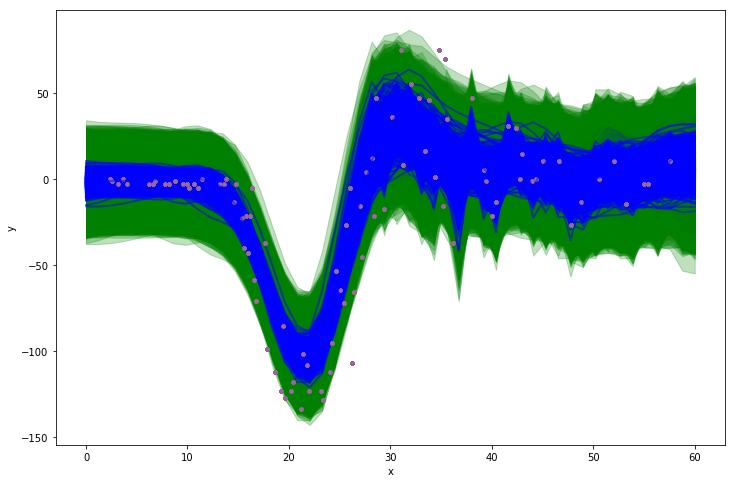

In [18]:
mini = 205
maxi = 1500
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], var_f_mat[i,:], noise_var[i])  

In [19]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

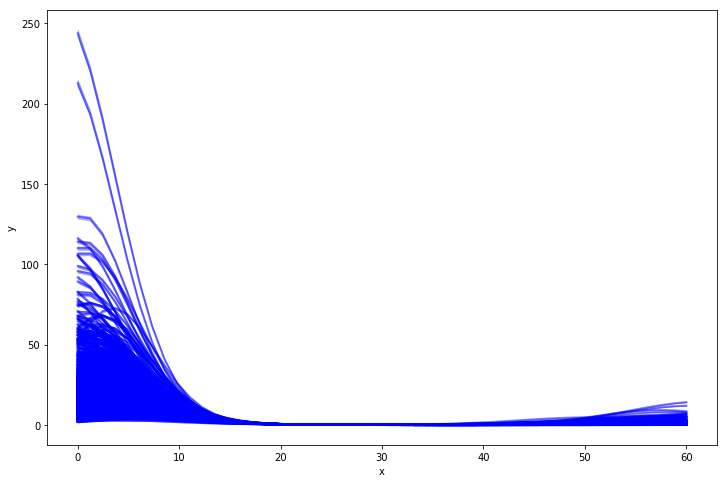

In [20]:
mini = 205
maxi = 1500
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_l(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [21]:
print Xnorm.shape
print Y[:,None].shape
print xx.shape

(94, 1)
(94, 1)
(50, 1)
